***Practice of various convolution techniques of begginer datasets***

## MNIST

In [0]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled=False
torch.manual_seed(random_seed)


In [0]:
!mkdir data

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

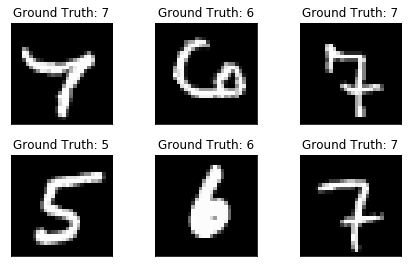

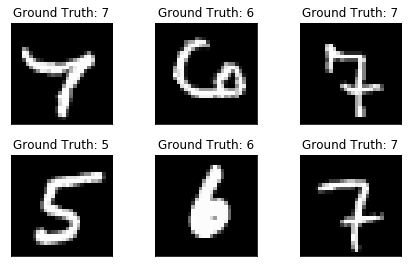

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [28]:
import numpy as np
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
dtype = torch.FloatTensor # the CPU datatype
x = torch.randn(1000, 1, 28, 28).type(dtype)
ans = network(x)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([1000, 10]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


True

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/data/model.pth')
      torch.save(optimizer.state_dict(), '/data/optimizer.pth')

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.273999
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251667
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236732
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223633
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.152995
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.095967
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974668
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.946443
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.842159
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.767566
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.699195
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.688624
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.511851
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.387024
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.284238
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.334326
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.271381
Train Epoch: 1 [12160/6

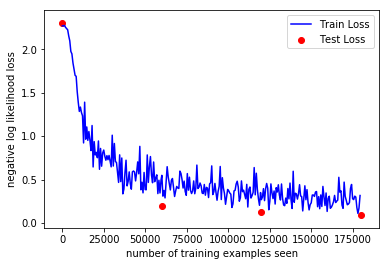

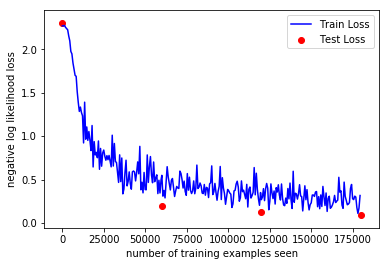

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [15]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


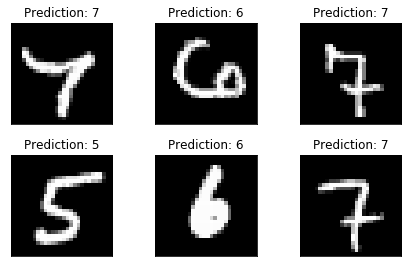

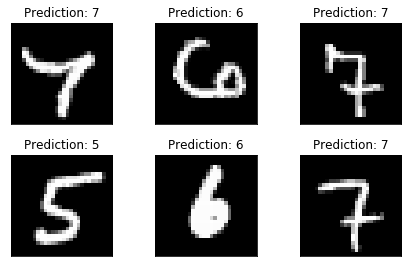

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [0]:
network_state_dict = torch.load('/data/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/data/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [21]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.353509
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.313774
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.181739
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.135925
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.366328
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.603716
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.290443
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.288632
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.312127
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.237762
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.496773
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.197844
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.247877
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.168497
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.296261
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.181420
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.158570
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.245574
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.352043
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.311598
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0827, Accuracy: 9741/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.369924
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.233222
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.296627
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.240100
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.228212
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.361211
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.309595
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.156320
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.260564
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.294373
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.120069
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.242354
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.184900
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.248608
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.187750
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.182152
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.267007
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.356076
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.130465
Train Epoch: 5 [12160

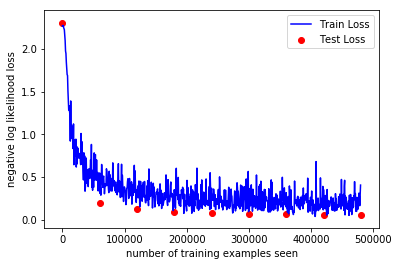

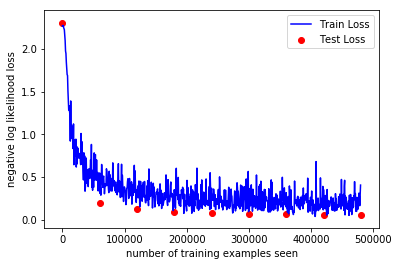

In [22]:

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

### Transfer learning

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled=False
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
for inputs, labels in test_loader:
  print(inputs.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [0]:
dataloaders = {'train' : train_loader,
               'val' : test_loader
              }

In [0]:
class_names = torchvision.datasets.MNIST.classes

In [9]:
for inputs, labels in dataloaders['val']:
  print(inputs.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [10]:
example_data.shape

torch.Size([1000, 1, 28, 28])

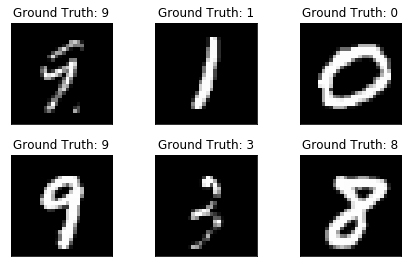

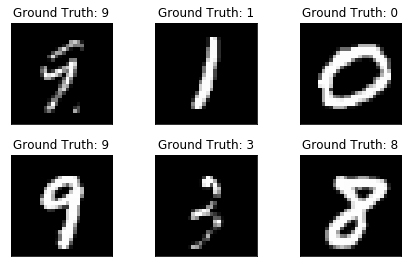

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 65252588.04it/s]


In [14]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [16]:
params = list(model_ft.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

62
torch.Size([64, 3, 7, 7])


In [20]:
input = torch.randn(3, 3, 32, 32).cuda()
out = model_ft(input)
print(out)

tensor([[-1.5106, -1.7874,  1.4930, -1.4711,  0.7650, -0.5939,  0.1170,  1.9220,
         -0.0048,  1.4414],
        [-0.0919,  0.3351, -0.3039,  0.1545, -0.8562,  0.3837, -0.0512, -1.1436,
          0.4743,  1.4525],
        [-0.8699, -0.3978,  0.0148, -0.1242,  0.0711,  0.4872,  0.6660,  0.6004,
          0.4003, -0.1294]], device='cuda:0', grad_fn=<AddmmBackward>)


In [21]:
import numpy as np
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
dtype = torch.FloatTensor # the CPU datatype
x = torch.randn(3, 3, 32, 32).to(device)
ans = model_ft(x)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([3, 10]))

True

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


RuntimeError: ignored

***ok!!! MNIST Dataset single channel***

## CIFAR-10

In [0]:
import torch
import torchvision

In [2]:
!mkdir cifar

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

mkdir: cannot create directory ‘cifar’: File exists


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/cifar/', train=True, download=True, 
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/cifar/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor()
                              ])),
  batch_size=batch_size_test, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_targets.shape

torch.Size([1000])

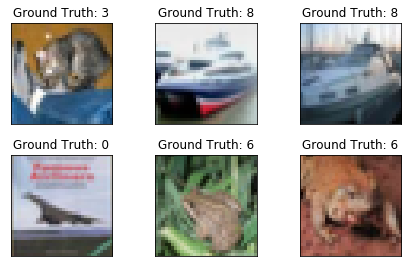

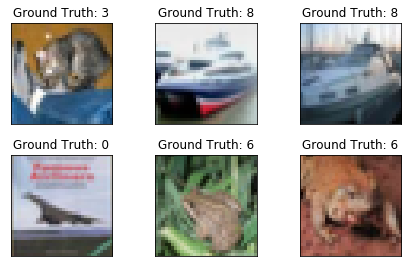

In [6]:
import matplotlib.pyplot as plt
import numpy

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].numpy().transpose((1, 2, 0)))
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  
fig

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 3, 5, 5])


In [10]:
input = torch.randn(1, 3, 32, 32)
out = net(input)
print(out)

tensor([[-0.0893,  0.0847,  0.0396,  0.0250,  0.0144, -0.0316, -0.1348, -0.0302,
          0.0967, -0.1002]], grad_fn=<AddmmBackward>)


In [11]:
import numpy as np
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
dtype = torch.FloatTensor # the CPU datatype
x = torch.randn(1, 3, 32, 32).type(dtype)
ans = net(x)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([1, 10]))

True

### Doesn't work??????

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(250, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 250)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [14]:
input = torch.randn(1, 3, 32, 32)
out = network(input)
print(out)

tensor([[-2.0785, -2.2416, -2.6690, -2.2566, -2.3991, -2.2158, -2.3308, -2.5327,
         -2.0266, -2.4506],
        [-2.1995, -2.6643, -2.0506, -2.4469, -2.3226, -2.3845, -2.2087, -2.4573,
         -2.1948, -2.2329]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
import numpy as np
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
dtype = torch.FloatTensor # the CPU datatype
x = torch.randn(1000, 3, 32, 32).type(dtype)
ans = net(x)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([1000, 10]))

True

### _________________________________

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/cifar/model.pth')
      torch.save(optimizer.state_dict(), '/cifar/optimizer.pth')

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [22]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0044, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.007921
Train Epoch: 1 [640/50000 (1%)]	Loss: -0.006819
Train Epoch: 1 [1280/50000 (3%)]	Loss: -0.046521
Train Epoch: 1 [1920/50000 (4%)]	Loss: -0.080529
Train Epoch: 1 [2560/50000 (5%)]	Loss: -0.110356
Train Epoch: 1 [3200/50000 (6%)]	Loss: -0.155412
Train Epoch: 1 [3840/50000 (8%)]	Loss: -0.196863
Train Epoch: 1 [4480/50000 (9%)]	Loss: -0.339012
Train Epoch: 1 [5120/50000 (10%)]	Loss: -1.954265
Train Epoch: 1 [5760/50000 (12%)]	Loss: nan
Train Epoch: 1 [6400/50000 (13%)]	Loss: nan
Train Epoch: 1 [7040/50000 (14%)]	Loss: nan
Train Epoch: 1 [7680/50000 (15%)]	Loss: nan
Train Epoch: 1 [8320/50000 (17%)]	Loss: nan
Train Epoch: 1 [8960/50000 (18%)]	Loss: nan
Train Epoch: 1 [9600/50000 (19%)]	Loss: nan
Train Epoch: 1 [10240/50000 (20%)]	Loss: nan
Train Epoch: 1 [10880/50000 (22%)]	Loss: nan
Train Epoch: 1 [11520/50000 (23%)]	Loss: nan
Train Epoch: 1 [12160/50000 (24%)]	Loss: nan
Train Epoch: 1 [1

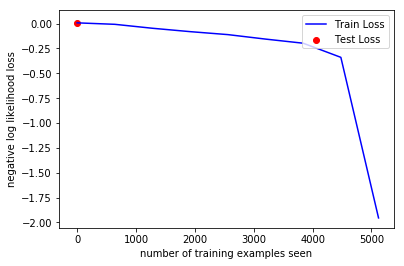

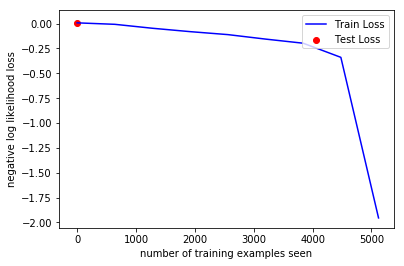

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [0]:
with torch.no_grad():
  output = network(example_data)

In [25]:
output.shape

torch.Size([1000, 10])

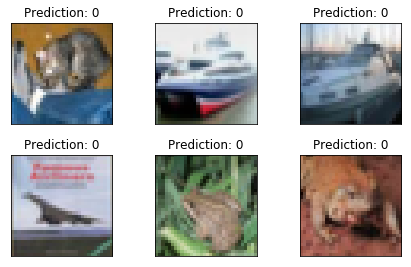

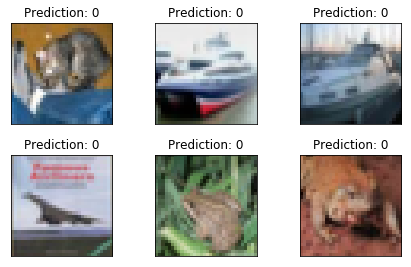

In [26]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].numpy().transpose((1, 2, 0)))
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
continued_network = net
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [0]:
network_state_dict = torch.load('/cifar/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/cifar/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [30]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

Train Epoch: 4 [0/50000 (0%)]	Loss: nan
Train Epoch: 4 [640/50000 (1%)]	Loss: nan
Train Epoch: 4 [1280/50000 (3%)]	Loss: nan
Train Epoch: 4 [1920/50000 (4%)]	Loss: nan
Train Epoch: 4 [2560/50000 (5%)]	Loss: nan
Train Epoch: 4 [3200/50000 (6%)]	Loss: nan
Train Epoch: 4 [3840/50000 (8%)]	Loss: nan
Train Epoch: 4 [4480/50000 (9%)]	Loss: nan
Train Epoch: 4 [5120/50000 (10%)]	Loss: nan
Train Epoch: 4 [5760/50000 (12%)]	Loss: nan
Train Epoch: 4 [6400/50000 (13%)]	Loss: nan
Train Epoch: 4 [7040/50000 (14%)]	Loss: nan
Train Epoch: 4 [7680/50000 (15%)]	Loss: nan
Train Epoch: 4 [8320/50000 (17%)]	Loss: nan
Train Epoch: 4 [8960/50000 (18%)]	Loss: nan
Train Epoch: 4 [9600/50000 (19%)]	Loss: nan
Train Epoch: 4 [10240/50000 (20%)]	Loss: nan
Train Epoch: 4 [10880/50000 (22%)]	Loss: nan
Train Epoch: 4 [11520/50000 (23%)]	Loss: nan
Train Epoch: 4 [12160/50000 (24%)]	Loss: nan
Train Epoch: 4 [12800/50000 (26%)]	Loss: nan
Train Epoch: 4 [13440/50000 (27%)]	Loss: nan
Train Epoch: 4 [14080/50000 (28%)]	Los

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: nan, Accuracy: 1000/10000 (10%)

Train Epoch: 5 [0/50000 (0%)]	Loss: nan
Train Epoch: 5 [640/50000 (1%)]	Loss: nan
Train Epoch: 5 [1280/50000 (3%)]	Loss: nan
Train Epoch: 5 [1920/50000 (4%)]	Loss: nan
Train Epoch: 5 [2560/50000 (5%)]	Loss: nan
Train Epoch: 5 [3200/50000 (6%)]	Loss: nan
Train Epoch: 5 [3840/50000 (8%)]	Loss: nan
Train Epoch: 5 [4480/50000 (9%)]	Loss: nan
Train Epoch: 5 [5120/50000 (10%)]	Loss: nan
Train Epoch: 5 [5760/50000 (12%)]	Loss: nan
Train Epoch: 5 [6400/50000 (13%)]	Loss: nan
Train Epoch: 5 [7040/50000 (14%)]	Loss: nan
Train Epoch: 5 [7680/50000 (15%)]	Loss: nan
Train Epoch: 5 [8320/50000 (17%)]	Loss: nan
Train Epoch: 5 [8960/50000 (18%)]	Loss: nan
Train Epoch: 5 [9600/50000 (19%)]	Loss: nan
Train Epoch: 5 [10240/50000 (20%)]	Loss: nan
Train Epoch: 5 [10880/50000 (22%)]	Loss: nan
Train Epoch: 5 [11520/50000 (23%)]	Loss: nan
Train Epoch: 5 [12160/50000 (24%)]	Loss: nan
Train Epoch: 5 [12800/50000 (26%)]	Loss: nan
Train Epoch: 5 [13440/50000 

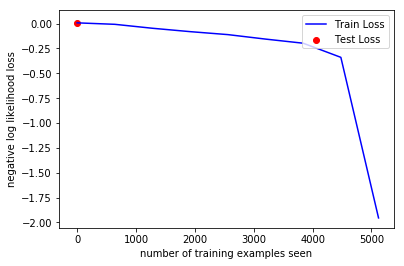

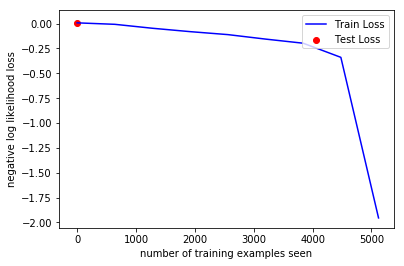

In [31]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

### Transfer learning

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled=False
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/cifar/', train=True, download=True, 
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/cifar/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor()
                              ])),
  batch_size=batch_size_test, shuffle=False)

dataset_sizes = {'train' : 50000,
                 'val' : 10000}


Files already downloaded and verified
Files already downloaded and verified


In [5]:
for inputs, labels in test_loader:
  print(inputs.shape)

torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [0]:
dataloaders = {'train' : train_loader,
               'val' : test_loader
              }

In [8]:
class_names = torchvision.datasets.CIFAR10.classes

AttributeError: ignored

In [9]:
for inputs, labels in dataloaders['val']:
  print(inputs.shape)

torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


In [10]:
example_data.shape

torch.Size([1000, 3, 32, 32])

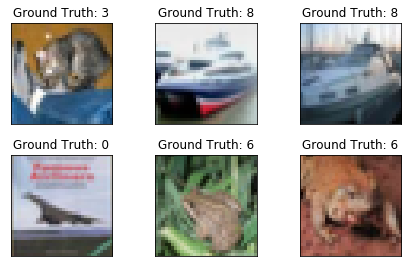

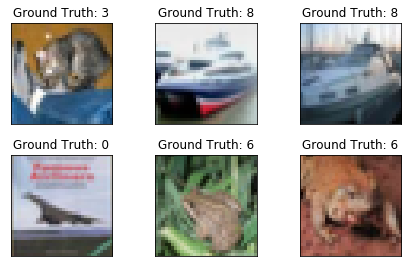

In [11]:
import matplotlib.pyplot as plt
import numpy

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].numpy().transpose((1, 2, 0)))
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  
fig

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
params = list(model_ft.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

62
torch.Size([64, 3, 7, 7])


In [16]:
input = torch.randn(3, 3, 32, 32).cuda()
out = model_ft(input)
print(out)

tensor([[ 0.2056,  0.5249, -0.2102,  0.0641, -0.2966, -0.8606,  0.7513,  0.0138,
         -0.1987, -0.8259],
        [ 0.2416,  0.4981,  1.4454,  0.5219, -1.1067, -1.6224,  0.4671,  0.5949,
          0.1723,  1.2881],
        [ 0.3541,  0.8457,  0.6046, -0.1059, -1.0411, -0.4205, -0.4714, -0.9650,
          1.5011,  0.5537]], device='cuda:0', grad_fn=<AddmmBackward>)


In [17]:
import numpy as np
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
dtype = torch.FloatTensor # the CPU datatype
x = torch.randn(3, 3, 32, 32).to(device)
ans = model_ft(x)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([3, 10]))

True

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0552 Acc: 0.6328
val Loss: 0.7276 Acc: 0.7453

Epoch 1/24
----------
train Loss: 0.6434 Acc: 0.7771
val Loss: 0.6518 Acc: 0.7798

Epoch 2/24
----------
train Loss: 0.4924 Acc: 0.8284
val Loss: 0.6174 Acc: 0.7905

Epoch 3/24
----------
train Loss: 0.3850 Acc: 0.8648
val Loss: 0.6149 Acc: 0.8007

Epoch 4/24
----------
train Loss: 0.2991 Acc: 0.8961
val Loss: 0.6408 Acc: 0.8060

Epoch 5/24
----------
train Loss: 0.2345 Acc: 0.9175
val Loss: 0.6668 Acc: 0.8065

Epoch 6/24
----------
train Loss: 0.1411 Acc: 0.9531
val Loss: 0.6365 Acc: 0.8179

Epoch 7/24
----------
train Loss: 0.1180 Acc: 0.9626
val Loss: 0.6608 Acc: 0.8163

Epoch 8/24
----------
train Loss: 0.1026 Acc: 0.9678
val Loss: 0.6614 Acc: 0.8181

Epoch 9/24
----------
train Loss: 0.0911 Acc: 0.9716
val Loss: 0.6655 Acc: 0.8168

Epoch 10/24
----------
train Loss: 0.0844 Acc: 0.9736
val Loss: 0.6839 Acc: 0.8175

Epoch 11/24
----------
train Loss: 0.0766 Acc: 0.9769
val Loss: 0.6938 Acc: 0.8186

Ep

### Downloading datasets:

In [0]:
#by folder
!wget http://files.fast.ai/data/cifar10.tgz

In [0]:
#by name:
!wget http://pjreddie.com/media/files/cifar.tgz    

### Preprocessing it for deep learning technique

***for simpler exploration of different techniques using cs231n datasets***

In [0]:
%%bash
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz

In [0]:
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
      mean_image = np.mean(X_train, axis=0)
      X_train -= mean_image
      X_val -= mean_image
      X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }
    

def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.

  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  - subtract_mean: Whether to subtract the mean training image.

  Returns: A dictionary with the following entries:
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  - mean_image: (3, 64, 64) array giving mean training image
  """
  # First load wnids
  with open(os.path.join(path, 'wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  with open(os.path.join(path, 'words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.iteritems():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        ## grayscale file
        img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      img_file, wnid = line.split('\t')[:2]
      img_files.append(img_file)
      val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        img.shape = (64, 64, 1)
      X_val[i] = img.transpose(2, 0, 1)

  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)

  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  
  mean_image = X_train.mean(axis=0)
  if subtract_mean:
    X_train -= mean_image[None]
    X_val -= mean_image[None]
    X_test -= mean_image[None]

  return {
    'class_names': class_names,
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'class_names': class_names,
    'mean_image': mean_image,
  }


def load_models(models_dir):
  """
  Load saved models from disk. This will attempt to unpickle all files in a
  directory; any files that give errors on unpickling (such as README.txt) will
  be skipped.

  Inputs:
  - models_dir: String giving the path to a directory containing model files.
    Each model file is a pickled dictionary with a 'model' field.

  Returns:
  A dictionary mapping model file names to models.
  """
  models = {}
  for model_file in os.listdir(models_dir):
    with open(os.path.join(models_dir, model_file), 'rb') as f:
      try:
        models[model_file] = load_pickle(f)['model']
      except pickle.UnpicklingError:
        continue
  return models


In [0]:
import random
import numpy as np
#from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
cifar10_dir = 'cifar-10-batches-py'

try:
  del X_train, y_train
  del X_test, y_test
  print('Clearn previously loaded data.')
except:
  pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### KNN

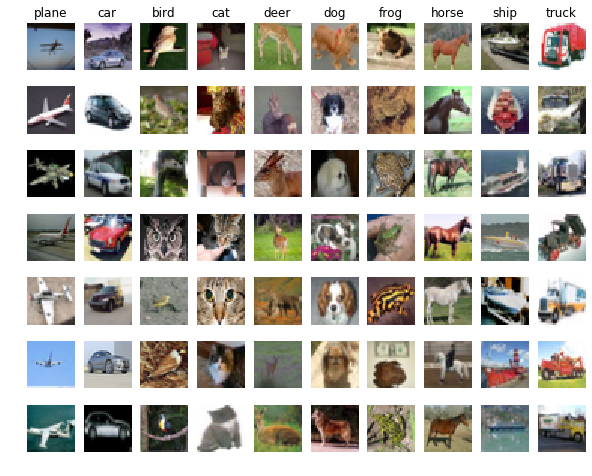

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
  idxs = np.flatnonzero(y_train == y)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i*num_classes + y + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')
    if i == 0:
      plt.title(cls)

plt.show()

In [0]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [0]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
#using L1 distance:

class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

    return Ypred

In [0]:
#from lecture:L1
nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(X_train, y_train) # train the classifier on the training images and labels
Yte_predict = nn.predict(X_test) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print ('accuracy: %f' % ( np.mean(Yte_predict == y_test) ))

accuracy: 0.290000


In [0]:
#using L2:
class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
     #distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

    return Ypred

In [0]:
#from lecture:L2
nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(X_train, y_train) # train the classifier on the training images and labels
Yte_predict = nn.predict(X_test) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print ('accuracy: %f' % ( np.mean(Yte_predict == y_test) ))

accuracy: 0.274000


In [0]:
from statistics import *
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension.                                    #
        #####################################################################
        dists[i,j] = np.sqrt(np.sum(np.square(self.X_train[j,:] - X[i,:])))        
        #dists[i,j] = np.linalg.norm(X[i, :] - self.X_train[j, :])
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis =1))
      #pass
      #######################################################################
      #                         END OF YOUR CODE                            #
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    x_norms = np.sum(X ** 2, axis=1).reshape(-1, 1)
    # shape (num_train, )
    x_train_norms = np.sum(self.X_train ** 2, axis=1)
    # summing arrays of shapes (num_test, 1) and (num_train, )
    # gives exactly the necessary shape (num_test, num_train). It's broadcasting.
    dists = (x_norms + x_train_norms - 2 * X.dot(self.X_train.T)) ** .5    
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    #dists = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
    #pass
    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      #closest_y = []
      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
      closest_y = np.argsort(dists[i,:])[:k]
      #dists = np.argsort(dists)
      #min_indexes = dists[i][0:k]
      #closest_y = [self.y_train[x] for x in min_indexes]
      #min_index = dists[i,0]
      #y_pred = self.y_train[min_index] #predict the label of the nearest example    return Ypred
      #closets_y.append(y_pred)
      #closest_y = [x for x in dists[]]      
      #pass
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
      neighbor_labels = self.y_train[closest_y]
      label_counts = np.bincount(neighbor_labels)
      y_pred[i] = np.argmax(label_counts)
      #y_pred[i] = max(set(closest_y), key=closest_y.count)
      #y_pred[i] = mode(closest_y)
      #pass
      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred

In [0]:
#Knearest neighbor
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [0]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


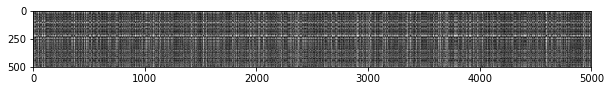

In [0]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [0]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [0]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [0]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [0]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [0]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 33.298266 seconds
One loop version took 45.554598 seconds
No loop version took 0.488745 seconds


In [0]:
%%time

from tqdm import tqdm_notebook


num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
split_idx = np.array_split(range(X_train.shape[0]), num_folds)

X_train_folds = np.array([X_train[train_idx] for train_idx in split_idx])
y_train_folds = np.array([y_train[train_idx].reshape(-1,1)
                          for train_idx in split_idx])

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

knn = KNearestNeighbor()

for k in tqdm_notebook(k_choices):
    accuracies = []
    for i in range(num_folds):
        all_other_fold_idx = list(set(range(num_folds)).difference([i]))
        X_train_cv = np.vstack(X_train_folds[all_other_fold_idx])
        y_train_cv = np.vstack(y_train_folds[all_other_fold_idx]).flatten()
        X_valid_cv = X_train_folds[i]  
        y_valid_cv = y_train_folds[i].flatten()
        
        knn.train(X_train_cv, y_train_cv)   

        knn_valid_pred = knn.predict(X_valid_cv, k=k, num_loops=0)

    
        num_correct = np.sum(knn_valid_pred == y_valid_cv)
        accuracy = float(num_correct) / y_valid_cv.shape[0]
        
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies
    
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, acc

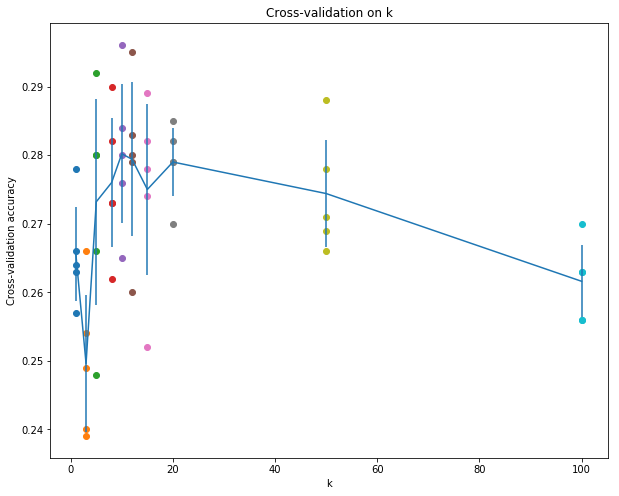

In [0]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [0]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


### SVM

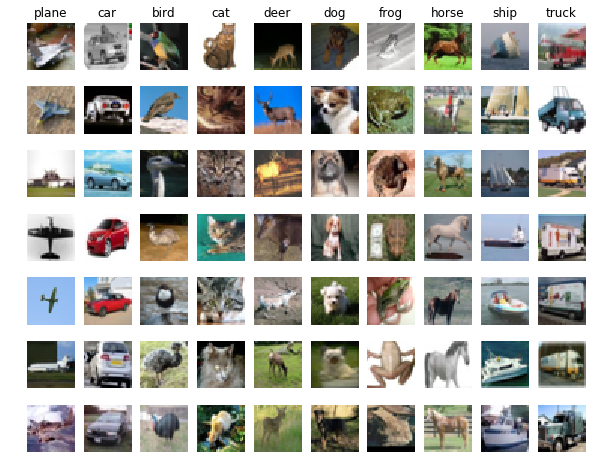

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [0]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


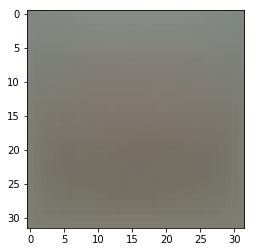

In [0]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [0]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [0]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [0]:
#linear_svm
import numpy as np


def svm_loss_naive(w, x, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    :param w: A numpy array of shape (D, C) containing weights.
    :param x: A numpy array of shape (N, D) containing a mini-batch of data.
    :param y: A numpy array of shape (N,) containing training labels; y[i] = c means
              that x[i] has label c, where 0 <= c < C.
    :param reg: (float) regularization strength
    :return: Returns a tuple of:
             - loss as single float
             - gradient with respect to weights W; an array of same shape as W
    """

    dw = np.zeros(w.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = w.shape[1]
    num_train = x.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = x[i].dot(w)
        correct_class_score = scores[y[i]]
        # we'll count the number of classes that didn’t meet the desired margin
        num_positive_margin = 0
      
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                # if the current class does't meet the desired margin, remember it
                num_positive_margin += 1
                # if the current class does't meet the desired margin, increment the gradient w.r.t.
                # to the current incorrect class by X_i
                dw[:, j] += x[i, :]
        # decrement the gradient w.r.t. to the correct class by X_i times the number of times other
        # classes didn’t meet the desired margin
        dw[:, y[i]] -= num_positive_margin * x[i, :]

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    dw /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(w * w)
    dw += 2 * reg * w

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################

    return loss, dw


def svm_loss_vectorized(w, x, y, reg):
    """
    Structured SVM loss function, vectorized implementation.
    Inputs and outputs are the same as svm_loss_naive.
    """
    num_train = x.shape[0]
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # shape (num_train, num_classes)
    scores = x.dot(w)
    # select in each row i the score at position y[i]
    correct_class_scores = scores[range(num_train), y].reshape(-1, 1)
    # compute margins row-wise, shape (num_train, num_classes)
    margins = scores - correct_class_scores + 1
    # compute SVM loss
    loss = margins.clip(min=0).sum() - num_train
    loss /= num_train
    loss += reg * np.sum(w * w)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################

    # where the margins are positive, shape (num_train, num_classes)
    idx_positive_margins = np.greater(margins, 0).astype('int')
    # for each object and correct class substract the number of positive margins
    idx_positive_margins[range(num_train), y] -= idx_positive_margins.sum(axis=1)
    # multiple X transposed by the previous matrix
    dw = x.T.dot(idx_positive_margins)
    dw /= num_train
    dw += 2 * reg * w
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dw

In [0]:
# Evaluate the naive implementation of the loss we provided for you:
#from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.726472


In [0]:
from __future__ import print_function

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
  """
  Compute numeric gradients for a function that operates on input
  and output blobs.
  
  We assume that f accepts several input blobs as arguments, followed by a blob
  into which outputs will be written. For example, f might be called like this:

  f(x, w, out)
  
  where x and w are input Blobs, and the result of f will be written to out.

  Inputs: 
  - f: function
  - inputs: tuple of input blobs
  - output: output blob
  - h: step size
  """
  numeric_diffs = []
  for input_blob in inputs:
    diff = np.zeros_like(input_blob.diffs)
    it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      orig = input_blob.vals[idx]

      input_blob.vals[idx] = orig + h
      f(*(inputs + (output,)))
      pos = np.copy(output.vals)
      input_blob.vals[idx] = orig - h
      f(*(inputs + (output,)))
      neg = np.copy(output.vals)
      input_blob.vals[idx] = orig
      
      diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

      it.iternext()
    numeric_diffs.append(diff)
  return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
  return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))



In [0]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
# from assignment1.cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.401933 analytic: -6.417544, relative error: 1.217708e-03
numerical: -2.196941 analytic: -2.196941, relative error: 1.584186e-10
numerical: 9.913321 analytic: 9.913321, relative error: 3.515121e-11
numerical: 7.294915 analytic: 7.294915, relative error: 4.184288e-11
numerical: 2.720319 analytic: 2.722856, relative error: 4.661397e-04
numerical: 8.542651 analytic: 8.542651, relative error: 2.266845e-11
numerical: -6.570177 analytic: -6.584053, relative error: 1.054860e-03
numerical: 19.825050 analytic: 19.825050, relative error: 5.132919e-12
numerical: -1.875635 analytic: -1.875635, relative error: 1.370844e-10
numerical: 1.917496 analytic: 1.917496, relative error: 4.356402e-11
numerical: 11.421686 analytic: 11.421686, relative error: 3.519319e-11
numerical: -7.226577 analytic: -7.226577, relative error: 2.646071e-12
numerical: -38.346526 analytic: -38.346526, relative error: 2.948510e-12
numerical: 17.805703 analytic: 17.805703, relative error: 3.102870e-11
numerical: 3.3

In [0]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from assignment1.cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.726472e+00 computed in 0.098702s
Vectorized loss: 8.726472e+00 computed in 0.010078s
difference: -0.000000


In [0]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.092367s
Vectorized loss and gradient: computed in 0.005574s
difference: 0.000000


In [0]:
#linear_classifier.py
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, x, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :param y: A numpy array of shape (N,) containing training labels; y[i] = c
                  means that X[i] has label 0 <= c < C for C classes.
        :param learning_rate: (float) learning rate for optimization.
        :param reg: (float) regularization strength.
        :param num_iters: (integer) number of steps to take when optimizing
        :param batch_size: (integer) number of training examples to use at each step.
        :param verbose: (boolean) If true, print progress during optimization.
        :return loss_history: A list containing the value of the loss function at each training iteration.
        """

        num_train, dim = x.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []

        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            idx = np.random.choice(range(x.shape[0]), size=batch_size)
            x_batch, y_batch = x[idx, :], y[idx]
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(x_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO: Update the weights using the gradient and the learning rate.    #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, x):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :return y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
                        array of length N, and each element is an integer giving the
                        predicted class.
        """
        ###########################################################################
        # TODO: Implement this method. Store the predicted labels in y_pred.      #
        ###########################################################################
        y_pred = np.argmax(x.dot(self.W), axis=1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, x_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        :param x_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        :param y_batch: A numpy array of shape (N,) containing labels for the mini-batch.
        :param reg: (float) regularization strength.
        :return: A tuple containing:
                     - loss as a single float
                     - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, x_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, x_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, x_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, x_batch, y_batch, reg)

In [0]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
#from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 779.832345
iteration 100 / 1500: loss 284.672134
iteration 200 / 1500: loss 106.852609
iteration 300 / 1500: loss 41.829582
iteration 400 / 1500: loss 18.491876
iteration 500 / 1500: loss 10.246716
iteration 600 / 1500: loss 7.153316
iteration 700 / 1500: loss 5.936243
iteration 800 / 1500: loss 5.165971
iteration 900 / 1500: loss 5.332524
iteration 1000 / 1500: loss 5.096046
iteration 1100 / 1500: loss 5.287303
iteration 1200 / 1500: loss 5.178872
iteration 1300 / 1500: loss 5.198687
iteration 1400 / 1500: loss 5.247994
That took 21.864980s


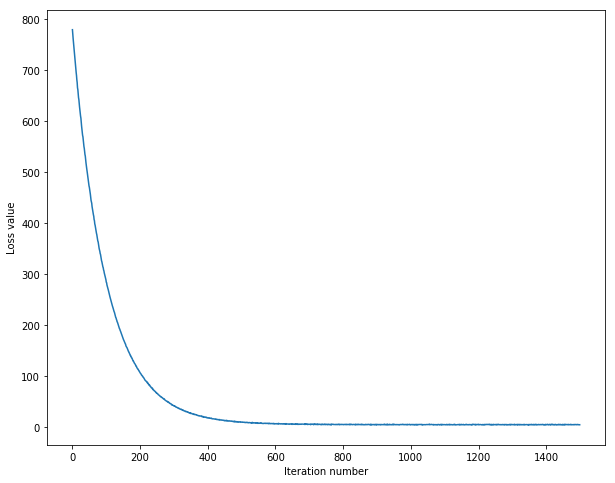

In [0]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [0]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371082
validation accuracy: 0.385000


In [0]:
%%time

from tqdm import tqdm_notebook

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = np.linspace(1.5e-7, 3e-7, 10)
regularization_strengths = np.linspace(0.5e3, 2e4, 10)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        svm = LinearSVM()
        _ = svm.train(X_train, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [0]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [0]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

In [0]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Softmax

In [0]:
import random
import numpy as np
from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'assignment1/cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

In [0]:
import numpy as np
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_classes  = W.shape[1]
  num_train = X.shape[0]
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    max_score = scores.max()
    scores -= max_score
    loss += -correct_class_score + max_score + np.log(np.exp(scores).sum())
    for j in range(num_classes):
      dw[:, j] += np.exp(scores[j]) / np.exp(scores).sum * x[i, :]
      
    dw[:, y[i]] -= x[i, :]
    
  loss /= num_train
  loss += reg * np.sum(W * W)
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  
  #pass
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  pass
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW



In [0]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

#from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

In [0]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from assignment1.cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

In [0]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

In [0]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
#from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [0]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

In [0]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Practice

In [0]:
import random
import numpy as np
#from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

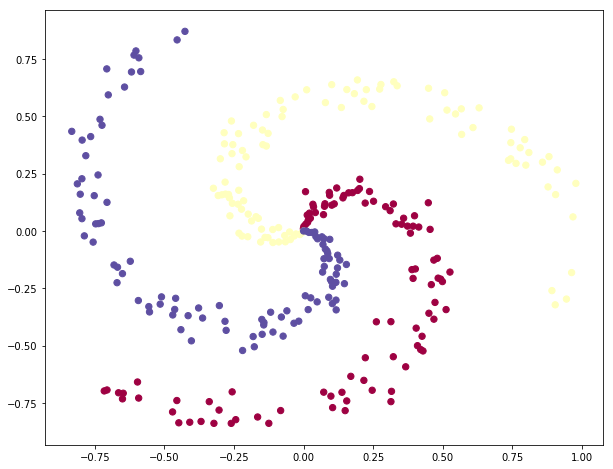

In [0]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [0]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
reg = 1e-3

In [0]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

In [0]:
num_examples = X.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [0]:
correct_logprobs = -np.log(probs[range(num_examples),y])

In [0]:
probs.shape

(300, 3)

In [0]:
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

In [0]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

In [0]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # don't forget the regularization gradient

In [0]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print ("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.097890
iteration 10: loss 0.909861
iteration 20: loss 0.839940
iteration 30: loss 0.808154
iteration 40: loss 0.791641
iteration 50: loss 0.782282
iteration 60: loss 0.776653
iteration 70: loss 0.773120
iteration 80: loss 0.770832
iteration 90: loss 0.769315
iteration 100: loss 0.768290
iteration 110: loss 0.767587
iteration 120: loss 0.767099
iteration 130: loss 0.766757
iteration 140: loss 0.766516
iteration 150: loss 0.766345
iteration 160: loss 0.766222
iteration 170: loss 0.766134
iteration 180: loss 0.766071
iteration 190: loss 0.766025


In [0]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.51


In [0]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

In [0]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

In [0]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

In [0]:
dhidden = np.dot(dscores, W2.T)

In [0]:
dhidden[hidden_layer <= 0] = 0

In [0]:
# finally into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

In [0]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print ("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098657
iteration 1000: loss 0.274250
iteration 2000: loss 0.269589
iteration 3000: loss 0.263319
iteration 4000: loss 0.253217
iteration 5000: loss 0.249915
iteration 6000: loss 0.249519
iteration 7000: loss 0.249047
iteration 8000: loss 0.248773
iteration 9000: loss 0.248588


In [0]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98


In [0]:
!mkdir data
!tar -xzf cifar10.tgz -C data/
!rm cifar10.tgz

In [0]:
PATH = "data/cifar10/train"
!ls {PATH}

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
data_dir = "data/cifar10/train"
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(32),
                                           transforms.RandomCrop(32),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(32),
                                          transforms.RandomCrop(32),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

In [0]:
#using pretrained models:
!pip3 install pretrainedmodels

In [0]:
import pretrainedmodels
print(pretrainedmodels.model_names)
print(pretrainedmodels.pretrained_settings['polynet'])

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)
print(model)

In [0]:
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

In [0]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [0]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

In [0]:
torch.save(model, 'cifar10.pth')

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

***testing model***

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable


In [0]:
data_dir = 'data/cifar10/test'

test_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.RandomCrop(32),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cifar10.pth')
model.eval()
model

In [0]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [0]:
to_pil = transforms.ToPILImage()
num = 5
data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes
indices = list(range(len(data)))
np.random.shuffle(indices)
idx = indices[:num]
from torch.utils.data.sampler import SubsetRandomSampler
sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
dataiter = iter(loader)
images, labels = dataiter.next()
classes = data.classes
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

### How image size is distributed

In [0]:
#to use fastai 0.7
!pip install fastai==0.7
!pip install torchtext==0.2.3

In [0]:
#basic imports:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
from os import listdir
from os.path import join
PATH = "data/cifar10"
train_path = f'{PATH}/train'

In [0]:
dirs = [d for d in listdir(train_path) if os.path.isdir(join(train_path,d))]
print(dirs)

In [0]:
train_dict = {d: listdir(join(train_path, d)) for d in dirs}

In [0]:
train_dict["dog"][:10]

In [0]:
sum(len(v) for v in train_dict.values())

In [0]:
with open(f"{PATH}/train.csv", "w") as csv:
    csv.write("img,label\n")
    for d in dirs:
        for f in train_dict[d]: csv.write(f'{f},{d}\n')

In [0]:
img_path = f'{PATH}/images'
os.makedirs(img_path, exist_ok=True)

In [0]:
!cp {PATH}/train/*/* {PATH}/images/

In [0]:
import os
import shutil

for root, dirs, files in os.walk('data/cifar10/train'):  # replace the . with your starting directory
   for file in files:
      path_file = os.path.join(root,file)
      shutil.copy2(path_file,'data/cifar10/images') # change you destination dir

In [0]:
PATH = 'data/cifar10/'
!ls {PATH}
label_csv = f'{PATH}train.csv'
label_df = pd.read_csv(label_csv)
label_df.head()

In [0]:
#how many images belong to specific class
label_df.pivot_table(index="label", aggfunc=len).sort_values('img', ascending=False)

In [0]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [0]:
arch = resnet18
bs = 64
sz = 32
PATH = 'data/cifar10/'
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'images', f'{PATH}train.csv',  # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

In [0]:
fn = PATH + data.trn_ds.fnames[0]; fn

In [0]:
img = PIL.Image.open(fn); img

In [0]:
img.size

In [0]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [0]:
row_sz, col_sz = list(zip(*size_d.values()))

In [0]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [0]:
row_sz[:5]

In [0]:
plt.hist(row_sz);

In [0]:
plt.hist(row_sz[row_sz < 1000])

In [0]:
plt.hist(col_sz);

In [0]:
plt.hist(col_sz[col_sz < 1000])

### To move files

In [0]:
%%bash
pwd
cd data
cd cifar
cd train && find . | grep -o [a-z]*.png | sort -u && cd .

In [0]:
!mkdir data/cifar/train_
!mkdir data/cifar/test_

In [0]:
!cd data/cifar/train_ && mkdir airplane automobile bird cat deer dog frog horse ship truck

In [0]:
%%bash
pwd
cd data
cd cifar
function copytrain { for arg in $@; do cp $(find train -name '*'$arg'.png') train_/$arg/; done; };
copytrain $(ls train_ | grep -o "[a-z]*")

In [0]:
!cd data/cifar/test_ && mkdir airplane automobile bird cat deer dog frog horse ship truck

In [0]:
%%bash
pwd
cd data
cd cifar
function copytest { for arg in $@; do cp $(find test -name '*'$arg'.png') test_/$arg/; done; };
copytest $(ls test_ | grep -o "[a-z]*")

In [0]:
%%bash
cd data
cd cifar
rm -rf train
rm -rf test
mv train_ train
mv test_ test

***OR***

In [0]:
#to move files with _yellow in name
#testing
%%bash
pwd
cd data
cd protein
cd train
mv *_yellow* yellow

#to look inside
%%bash
pwd
cd data
cd protein
cd train
ls -d -- *_green* | sort -t. -k2
